In [1]:
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
from pyvis.network import Network


In [2]:
## helper functions

def create_correlation_matrix(full_df, col_header, group, corr_metric, color):
    ''' Return correlation matrix with a the subset of entries from [full_df] defined
        by [col_header] == group with correlation metric defined by [corr_metric].
        Display historgram of values with color [color].
    '''
    subset_df = full_df[full_df[col_header] == group].drop(columns=[col_header])
    subset_df.replace(0, np.nan, inplace=True)
    subset_df = subset_df.dropna(how='all', axis=1)
    subset_df = subset_df.fillna(0)
    df_corr = subset_df.corr(corr_metric)
    
    # plot histrogram of correlation coefficients distribution
    fig, ax = plt.subplots()
    hist, bins = np.histogram(df_corr.stack())
    ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]),
          color=color)
    ax.set_title(f"{corr_metric} Distribution Histogram: {col_header}-{group}")
    ax.set_xlabel(f"{corr_metric} Correlation Coefficient")
    ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    return df_corr

def create_network(df_corr, thresh):
    df_thresh = df_corr.copy().fillna(0)
    df_thresh[abs(df_thresh) < thresh] = 0
    df_thresh[abs(df_thresh) >= thresh] = 1
    G = nx.from_pandas_adjacency(df_thresh)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

def get_stats(G):
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)
    num_cc = len(list(nx.connected_components(G)))
    density = nx.density(G)
    degree_dict = dict(G.degree())
    avg_degree = sum(degree_dict.values())/len(degree_dict)
    highest_degree = max(degree_dict.values())
    max_degree_list = [(k,v) for k,v in degree_dict.items() if v == highest_degree]
    highest_degree_taxa = ', '.join([node for node, degree in max_degree_list])
    return [num_nodes, num_edges, num_cc, density, avg_degree, 
            highest_degree, highest_degree_taxa]

def get_top_n_degrees(G, n):
    deg_dict = dict(G.degree)
    sorted_deg_list = sorted(deg_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_deg_list[:n] 

def get_top_n_pagerank(G, n):
    pagerank_dict = nx.pagerank(G)
    sorted_pagerank_list = sorted(pagerank_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_pagerank_list[:n] 

def get_subgraph(df_corr, thresh, node_oi):
    df_thresh = df_corr.copy().fillna(0)
    df_thresh[abs(df_thresh) < thresh] = 0
    df_thresh = df_thresh.applymap(lambda x: round(x,2))
    G = nx.from_pandas_adjacency(df_thresh)
    G.remove_edges_from(nx.selfloop_edges(G))
    edges_oi = G.edges(node_oi)
    nodes_degree1 = [tup[1] for tup in list(edges_oi)] + [node_oi]
    return G.subgraph(nodes_degree1)

def draw_network(network):
    labels = nx.get_edge_attributes(network, "weight")
    fig, ax = plt.subplots(1, 1)
    layout = nx.circular_layout(network)
    nx.draw(network, layout, with_labels = True)
    nx.draw_networkx_edge_labels(network, ax=ax, pos=layout,
                             edge_labels=labels)
    plt.show()
    



In [3]:
## import data
abundance_df = pd.read_csv(f"spreadsheets/abundance-species-0.0001.tsv", index_col="species", sep='\t').transpose()
metadata_df = pd.read_csv("metadata_all.tsv", index_col='sample', sep='\t')

## reset abundance_df to not have duplicates
before_n = len(abundance_df)
abundance_df['remove_duplicate'] = metadata_df['remove_duplicate']
abundance_df = abundance_df[abundance_df['remove_duplicate'] != 'y'].drop(columns=['remove_duplicate'])
after_n = len(abundance_df)

## remove antiobiotic treated samples
abundance_df['antibiotic'] = metadata_df['Antibiotic']
abundance_df = abundance_df[abundance_df['antibiotic'] != 'Antibiotic'].drop(columns=['antibiotic'])


### MODEL 1: compare severity - mild/mod/severe/control at timepoints T0

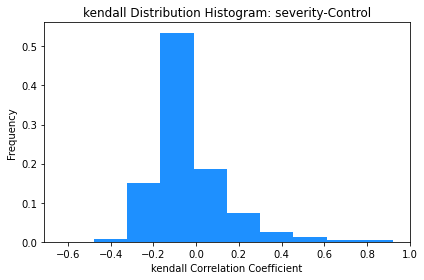

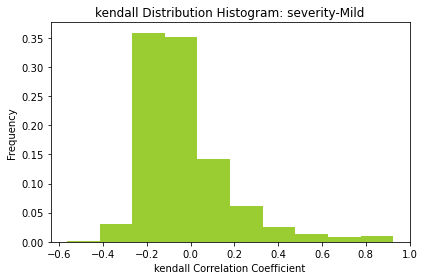

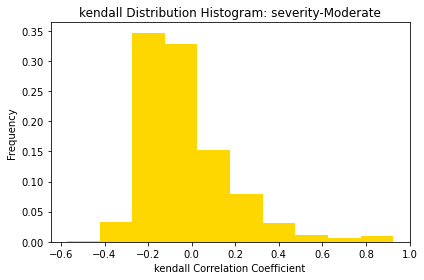

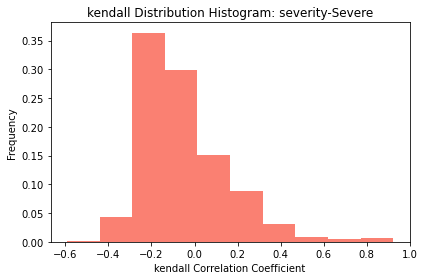

In [48]:
correlation_metric='kendall'

# define colors
severity_groups = ['control', 'mild', 'moderate', 'severe']
control_color = 'dodgerblue'
mild_color = 'yellowgreen'
moderate_color = 'gold'
severe_color = 'salmon'

# create dataframe of all abundances in model analysis
severity_df = abundance_df.copy().fillna(0)
severity_df['severity'] = metadata_df['COVID19_severity']
severity_df['timepoint'] = metadata_df['Time (T0/14)']
severity_df_0 = severity_df[severity_df['timepoint']
                            .isin(['T0', 'Control'])].drop(columns=['timepoint'])

## create a separate dataframe of abundances
pearson_control = create_correlation_matrix(severity_df_0, 'severity', 
                                            'Control', correlation_metric, control_color)
pearson_mild = create_correlation_matrix(severity_df_0, 'severity', 
                                            'Mild', correlation_metric, mild_color)
pearson_moderate = create_correlation_matrix(severity_df_0, 'severity', 
                                            'Moderate', correlation_metric, moderate_color)
pearson_severe = create_correlation_matrix(severity_df_0, 'severity', 
                                            'Severe', correlation_metric, severe_color)


In [44]:
## create co-occurence networks
corr_threshold = 0.5
top_n = 5
control_network = create_network(pearson_control, corr_threshold)
control_stats = get_stats(control_network)
display("control:", "top degree nodes",get_top_n_degrees(control_network, top_n))
display("pagerank", get_top_n_pagerank(control_network, top_n))
mild_network = create_network(pearson_mild, corr_threshold)
mild_stats = get_stats(mild_network)
display("mild:", "top degree nodes",get_top_n_degrees(mild_network, top_n))
display("pagerank", get_top_n_pagerank(mild_network, top_n))
moderate_network = create_network(pearson_moderate, corr_threshold)
moderate_stats = get_stats(moderate_network)
display("moderate:", "top degree nodes",get_top_n_degrees(moderate_network, top_n))
display("pagerank", get_top_n_pagerank(moderate_network, top_n))
severe_network = create_network(pearson_severe, corr_threshold)
severe_stats = get_stats(severe_network)
display("severe:", "top degree nodes",  get_top_n_degrees(severe_network, top_n))
display("pagerank", get_top_n_pagerank(severe_network, top_n))


# generate stats table for networks
stats_headers = ['number of nodes', 'number of edges',
           'number of connected components', 
           'network density', 'average degree',
            'highest degree', 'highest degree species']
stats = [control_stats, mild_stats, moderate_stats, severe_stats]
stats_df = pd.DataFrame(stats, columns = stats_headers, index = severity_groups)
stats_df


'control:'

'top degree nodes'

[('Lachnospiraceae bacterium oral taxon 500', 88),
 ('Wandonia haliotis', 88),
 ('Christensenella massiliensis', 84),
 ('Saccharofermentans acetigenes', 83),
 ('Intestinimonas butyriciproducens', 81)]

'pagerank'

[('Lachnospiraceae bacterium oral taxon 500', 0.0029942106382252693),
 ('Wandonia haliotis', 0.0029942106382252693),
 ('Faecalimonas umbilicata', 0.002934739508343613),
 ('Intestinimonas butyriciproducens', 0.0029054199695702455),
 ('Saccharofermentans acetigenes', 0.0028652660932776976)]

'mild:'

'top degree nodes'

[('Acetobacterium tundrae', 190),
 ('Fervidicella metallireducens', 189),
 ('Gottschalkia purinilytica', 189),
 ('Clostridium beijerinckii', 150),
 ('Clostridium grantii', 150)]

'pagerank'

[('Acetobacterium tundrae', 0.0034882562600580896),
 ('Fervidicella metallireducens', 0.0034810076676406116),
 ('Gottschalkia purinilytica', 0.0034810076676406116),
 ('Clostridium beijerinckii', 0.0027064739200808757),
 ('Clostridium grantii', 0.0027064739200808757)]

'moderate:'

'top degree nodes'

[('Aliidongia dinghuensis', 108),
 ('Georhizobium profundi', 108),
 ('Salimesophilobacter vulgaris', 107),
 ('Acetobacterium malicum', 101),
 ('Clostridium putrefaciens', 101)]

'pagerank'

[('Intestinimonas butyriciproducens', 0.0028311126701572762),
 ('Papillibacter cinnamivorans', 0.0028275412999454247),
 ('Salimesophilobacter vulgaris', 0.0028232788225275073),
 ('Marinibaculum pumilum', 0.0028153488610464473),
 ('Aliidongia dinghuensis', 0.0027245523948499395)]

'severe:'

'top degree nodes'

[('Gemella sanguinis', 51),
 ('Ihubacter massiliensis', 51),
 ('Campylobacter gracilis', 50),
 ('Colidextribacter massiliensis', 50),
 ('Acetivibrio ethanolgignens', 49)]

'pagerank'

[('Ihubacter massiliensis', 0.003533836335481594),
 ('Gemella sanguinis', 0.003508872609746613),
 ('Ruminiclostridium hungatei', 0.0034871224116578177),
 ('Lacrimispora saccharolytica', 0.0034365444482721648),
 ('Lachnospira multipara', 0.003433868686115642)]

number of nodes  number of edges  number of connected components  \
control               832             9421                              58   
mild                  841            15158                              35   
moderate              775            12948                               9   
severe                601             6452                               4   

          network density  average degree  highest degree  \
control          0.027252       22.646635              88   
mild             0.042914       36.047562             190   
moderate         0.043171       33.414194             108   
severe           0.035785       21.470882              51   

                                     highest degree species  
control   Lachnospiraceae bacterium oral taxon 500, Wand...  
mild                                 Acetobacterium tundrae  
moderate      Aliidongia dinghuensis, Georhizobium profundi  
severe            Gemella sanguinis, Ihubacter massiliensis

control


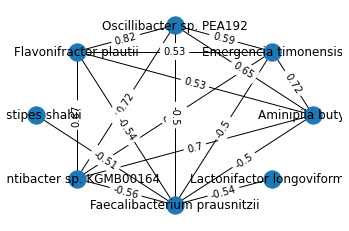

mild


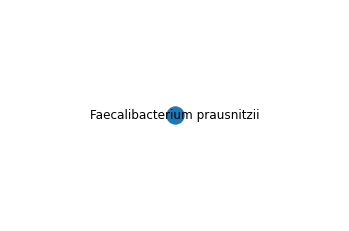

moderate


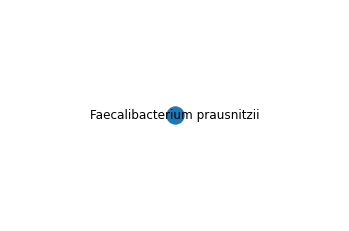

severe


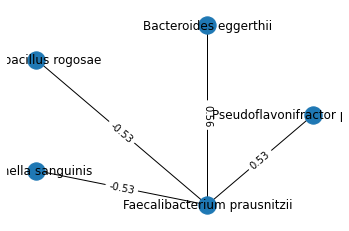

In [45]:
threshold = 0.5
species = 'Faecalibacterium prausnitzii'

print("control")
draw_network(get_subgraph(pearson_control, threshold, species))
print("mild")
draw_network(get_subgraph(pearson_mild, threshold, species))
print("moderate")
draw_network(get_subgraph(pearson_moderate, threshold, species))
print("severe")
draw_network(get_subgraph(pearson_severe, threshold, species))

In [46]:
threshold = 0.5
species = 'Blautia sp. SC05B48'

print("control")
draw_network(get_subgraph(pearson_control, threshold, species))
print("mild")
draw_network(get_subgraph(pearson_mild, threshold, species))
print("moderate")
draw_network(get_subgraph(pearson_moderate, threshold, species))
print("severe")
draw_network(get_subgraph(pearson_severe, threshold, species))

control


mild


moderate


severe


In [8]:
# display - control
'''net = Network(notebook=True)
net.from_nx(control_network)
net.show("control.html")'''

'net = Network(notebook=True)\nnet.from_nx(control_network)\nnet.show("control.html")'

In [9]:
# display - mild
'''net = Network(notebook=True)
net.from_nx(mild_network)
net.show("mild.html")'''

'net = Network(notebook=True)\nnet.from_nx(mild_network)\nnet.show("mild.html")'

In [49]:
# display - moderate
net = Network(notebook=True)
net.from_nx(moderate_network)
net.show("moderate.html")

In [11]:
# display - severe
'''net = Network(notebook=True)
net.from_nx(severe_network)
net.show("severe.html")'''

'net = Network(notebook=True)\nnet.from_nx(severe_network)\nnet.show("severe.html")'

### MODEL 2a: Longitudinal change before/after treatment - tannins vs placebo

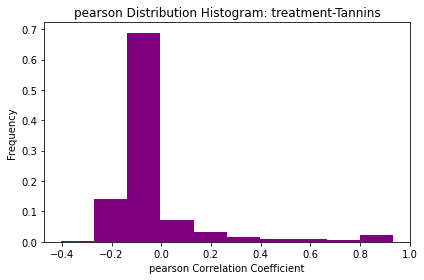

In [12]:
# define colors
treatment_groups = ['placebo', 'tannins']
placebo_color = 'grey'
tannins_color = 'purple'

## keep only patients with both timepoints 
patients = metadata_df['DNI'].unique()
patients_longitudinal = []
for p in patients:
    l = list(metadata_df[metadata_df['DNI'] == p]['Time (T0/14)'])
    if(set(l) == {'T0','T14'}):
        patients_longitudinal.append(p)

# create dataframe of all difference for abundances in model analysis
change_df = abundance_df.copy().fillna(0)
change_df['timepoint'] = metadata_df['Time (T0/14)']
change_df['DNI'] = metadata_df['DNI']
change_df = change_df[change_df['DNI'].isin(patients_longitudinal)]
change_df_0 = change_df[change_df['timepoint'].isin(['T0'])].drop(columns=['timepoint']).set_index('DNI')
change_df_14 = change_df[change_df['timepoint'].isin(['T14'])].drop(columns=['timepoint']).set_index('DNI')
change_df = abs(change_df_14 - change_df_0)

patient_treatment = metadata_df[['Treatment','DNI']].set_index('DNI')
patient_treatment = patient_treatment[~patient_treatment.index.duplicated(keep='first')]
change_df['treatment'] = patient_treatment['Treatment']


## create a separate dataframe of abundances
pearson_placebo = create_correlation_matrix(change_df, 'treatment', 
                                            'Placebo', 'pearson', placebo_color)
pearson_tannins = create_correlation_matrix(change_df, 'treatment', 
                                            'Tannins', 'pearson', tannins_color)


In [13]:
## create co-occurence networks
corr_threshold = 0.5
placebo_network = create_network(pearson_placebo, corr_threshold)
placebo_stats = get_stats(placebo_network)
display("placebo:", "top degree nodes", get_top_n_degrees(placebo_network, top_n))
display("pagerank", get_top_n_pagerank(placebo_network, top_n))
tannins_network = create_network(pearson_tannins, corr_threshold)
tannins_stats = get_stats(tannins_network)
display("tannins:", "top degree nodes", get_top_n_degrees(tannins_network, top_n))
display("pagerank", get_top_n_pagerank(tannins_network, top_n))


# generate stats table for networks
stats_headers = ['number of nodes', 'number of edges',
           'number of connected components', 
           'network density', 'average degree',
            'highest degree', 'highest degree species']
stats = [placebo_stats, tannins_stats]
stats_df = pd.DataFrame(stats, columns = stats_headers, index = treatment_groups)
stats_df


'placebo:'

'top degree nodes'

[('Clostridium sp. JN-9', 139),
 ('Mucinivorans hirudinis', 139),
 ('Sedimentibacter acidaminivorans', 139),
 ('Fervidicella metallireducens', 135),
 ('Prevotella buccae', 128)]

'pagerank'

[('Mucinivorans hirudinis', 0.0020847620788377722),
 ('Sedimentibacter acidaminivorans', 0.0020847620788377722),
 ('Clostridium sp. JN-9', 0.002081512393668988),
 ('[Clostridium] hylemonae', 0.0020630085547187105),
 ('Fervidicella metallireducens', 0.002058841427413217)]

'tannins:'

'top degree nodes'

[('Fervidicella metallireducens', 157),
 ('Gottschalkia purinilytica', 156),
 ('Christensenella minuta', 145),
 ('Christensenella timonensis', 143),
 ('Mycoplasma yeatsii', 132)]

'pagerank'

[('Fervidicella metallireducens', 0.001945476245896608),
 ('Gottschalkia purinilytica', 0.001936207734379617),
 ('Mycoplasma yeatsii', 0.0018187934901698986),
 ('Clostridium jeddahense', 0.001816558687926231),
 ('Christensenella minuta', 0.0017923070109809084)]

number of nodes  number of edges  number of connected components  \
placebo              903            22748                               3   
tannins             1016            22688                               7   

         network density  average degree  highest degree  \
placebo         0.055857       50.383167             139   
tannins         0.044001       44.661417             157   

                                    highest degree species  
placebo  Clostridium sp. JN-9, Mucinivorans hirudinis, ...  
tannins                       Fervidicella metallireducens

In [16]:
# display - placebo
net = Network(notebook=True)
net.from_nx(placebo_network)
net.show("placebo.html")

In [17]:
# display - tannins
net = Network(notebook=True)
net.from_nx(tannins_network)
net.show("tannins.html")